In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GridSearchCV, ParameterGrid,
                                     RandomizedSearchCV)
from tools import (Modelisation, datasets, SearchCV, restauration_CV, 
                   graph_2scores_CV, graph_3scores_CV, graph_param_CV, 
                   best_score_CV)

## Matplotlib : 
# Pour affichage interactif (notamment 3D) dans notebook
# %matplotlib widget

# Pour affichage interactif (notamment 3D) dans une fenêtre qt externe au notebook
# %matplotlib qt

# Pour affichage simple dans notebook
# %config InlineBackend.figure_format = 'png'

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df)
X_quant = datasets_df['X_quant']
X_cat = datasets_df['X_cat']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


Afin de comparer nos modèles en termes de performances brutes et de temps d'exécution, il est fondamental de déterminer quelques métriques de référence. Ici, il faut surtout faire en sorte d'éviter de prédire des non-clics qui seraient en réalité des clics (ie prédire trop de 0), quitte à prédire trop de 1. Autrement dit, il faut maximiser le recall et le NPV (Negative predictive value) afin de limiter les erreurs de type II. Le F1 Score, combinaison du recall et de la précision, est également pertinent. 

# Régression logistique
## Variables quantitatives

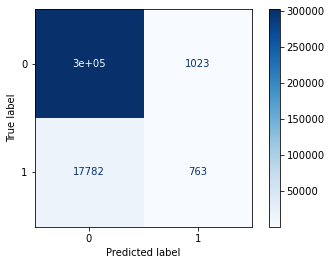

f1 : 0.0751
recall : 0.0411
negative predictive value : 0.9445
precision : 0.4272
roc_auc : 0.7387


In [4]:
m = Modelisation(X_quant, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

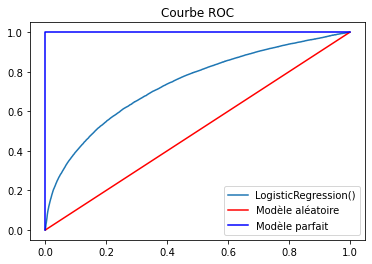

In [5]:
m.show_ROC()

In [6]:
coeff_df = pd.DataFrame(np.transpose(m.model.coef_), X_quant.columns, columns=['Coefficient'])
coeff_df

,Coefficient
contextid,-0.024760
campaignctrlast24h,0.362307
dayssincelastvisitdouble,-0.024485
ltf_nbglobaldisplay_4w,0.008765
ltf_nbpartnerdisplayssincelastclick,-0.021230
ltf_nbpartnerdisplay_90d,-0.013416
ltf_nbpartnerclick_90d,0.035591
ltf_nbpartnersales_90d,-0.009483
nbdayssincelastclick,-0.108439
nbdisplay_1hour,-0.224199


**Problème :** pas de scaling dans la cellule suivante

In [7]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

X_quant_scaled = datasets_df['X_quant_scaled']
X_ = add_constant(X_quant_scaled)
print(Logit(y, X_).fit().summary())

Optimization terminated successfully.
         Current function value: 0.197126
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     is_display_clicked   No. Observations:              1610494
Model:                          Logit   Df Residuals:                  1610480
Method:                           MLE   Df Model:                           13
Date:                Sat, 20 Feb 2021   Pseudo R-squ.:                 0.09804
Time:                        00:36:20   Log-Likelihood:            -3.1747e+05
converged:                       True   LL-Null:                   -3.5198e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0405      0.004   -761.677      0.000      -3.048      -3.033
x1            -0.0249      0.

Avec LASSO (+ univariate mais variable déjà exclue par Lasso): 

In [8]:
X1 = df[['contextid',
         'zonecostineuro',
         'campaignctrlast24h',
         'ltf_nbpartnerclick_90d',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'nbdisplayglobalapprox_1d_sum_xdevice']]
y1 = df['is_display_clicked']

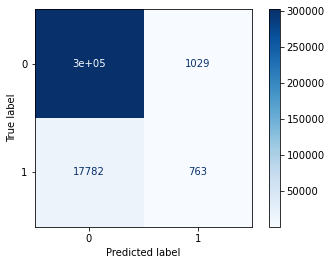

f1 : 0.0750
recall : 0.0411
negative predictive value : 0.9445
precision : 0.4258
roc_auc : 0.7383


In [9]:
m1 = Modelisation(X1, y1, LogisticRegression(), scaling=True)
m1.show_conf_matrix()
m1.show_metrics_score()

## Variables catégorielles

In [10]:
# Nombre de valeurs distinctes
from tools import COLUMNS_CAT
for column in COLUMNS_CAT:
    print(f"{column} : {len(set(df[column]))}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7
hour : 24
weekday : 7


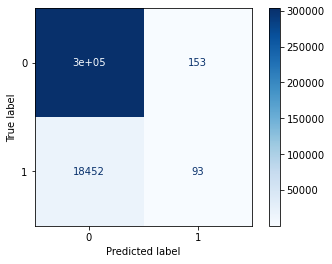

f1 : 0.0099
recall : 0.0050
negative predictive value : 0.9427
precision : 0.3780
roc_auc : 0.6855


In [11]:
m = Modelisation(X_cat, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

## Variables quantitatives + catégorielles

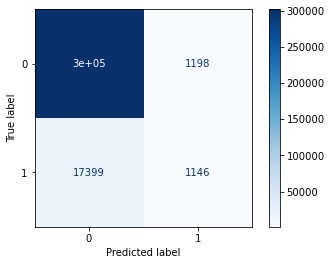

f1 : 0.1097
recall : 0.0618
negative predictive value : 0.9456
precision : 0.4889
roc_auc : 0.7545
CPU times: user 2min 15s, sys: 3min 50s, total: 6min 6s
Wall time: 12 s


In [12]:
%%time
m = Modelisation(X, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

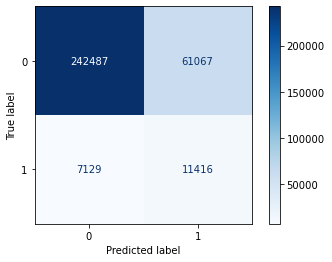

f1 : 0.2508
recall : 0.6156
negative predictive value : 0.9714
precision : 0.1575
roc_auc : 0.7762
CPU times: user 1min 47s, sys: 3min 21s, total: 5min 8s
Wall time: 10.9 s


In [13]:
%%time
m = Modelisation(X, y, LogisticRegression(class_weight='balanced'), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

Avec RFECV :

In [14]:
X2 = X[['zonecostineuro',
         'campaignctrlast24h',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'is_interstitial_True',
         'device_type_Desktop',
         'device_type_iPhone',
         'display_env_app_ios',
         'target_env_2',
         'campaignscenario_13']]
y2 = df['is_display_clicked']

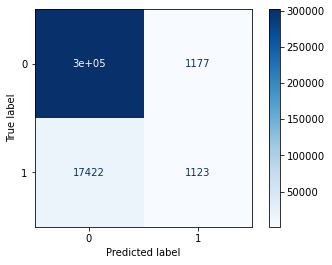

f1 : 0.1077
recall : 0.0606
negative predictive value : 0.9455
precision : 0.4883
roc_auc : 0.7515
CPU times: user 39.3 s, sys: 1min 39s, total: 2min 18s
Wall time: 3.77 s


In [15]:
%%time
m2 = Modelisation(X2, y2, LogisticRegression(), scaling=True)
m2.show_conf_matrix()
m2.show_metrics_score()

## Comparaison par rapport aux valeurs de C 

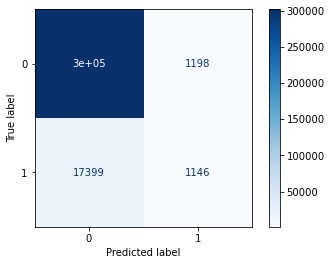

f1 : 0.1097
recall : 0.0618
negative predictive value : 0.9456
precision : 0.4889
roc_auc : 0.7545


In [16]:
m = Modelisation(X, y, LogisticRegression(C=0.2), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

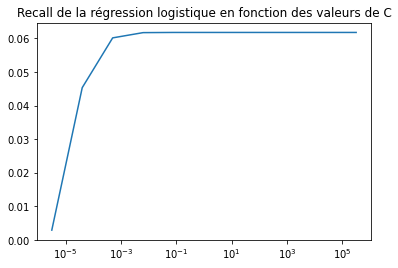

CPU times: user 21min 4s, sys: 36min 22s, total: 57min 26s
Wall time: 1min 50s


In [17]:
%%time
C, list_recall = [], []
for c in np.logspace(-5.5, 5.5, num=11): 
    m = Modelisation(X, y, LogisticRegression(C=c), scaling=True)
    C.append(c)
    list_recall.append(m.recall)
plt.plot(C, list_recall)
plt.xscale('log')
plt.title("Recall de la régression logistique en fonction des valeurs de C")
plt.show()

## Tuning des hyperparamètres avec GridSearchCV

In [18]:
model = LogisticRegression()

cv_params = {
        "C": np.logspace(-5, 4, 50),
        "class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:8}, {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16.5}] 
        }

print(len(ParameterGrid(cv_params)))

450


In [19]:
# SearchCV(model, cv_params, data_frac=1, scaling=True, random=False, n_jobs=28)

In [20]:
dico, results = restauration_CV('LR_CV_Grid_450_1')

model : LogisticRegression()
model_name : LR
type : GridSearchCV
len_grid : 450
data_frac : 1
temps : 00:30:28
params : {'C': array([1.00000000e-05, 1.52641797e-05, 2.32995181e-05, 3.55648031e-05,
       5.42867544e-05, 8.28642773e-05, 1.26485522e-04, 1.93069773e-04,
       2.94705170e-04, 4.49843267e-04, 6.86648845e-04, 1.04811313e-03,
       1.59985872e-03, 2.44205309e-03, 3.72759372e-03, 5.68986603e-03,
       8.68511374e-03, 1.32571137e-02, 2.02358965e-02, 3.08884360e-02,
       4.71486636e-02, 7.19685673e-02, 1.09854114e-01, 1.67683294e-01,
       2.55954792e-01, 3.90693994e-01, 5.96362332e-01, 9.10298178e-01,
       1.38949549e+00, 2.12095089e+00, 3.23745754e+00, 4.94171336e+00,
       7.54312006e+00, 1.15139540e+01, 1.75751062e+01, 2.68269580e+01,
       4.09491506e+01, 6.25055193e+01, 9.54095476e+01, 1.45634848e+02,
       2.22299648e+02, 3.39322177e+02, 5.17947468e+02, 7.90604321e+02,
       1.20679264e+03, 1.84206997e+03, 2.81176870e+03, 4.29193426e+03,
       6.55128557e+03,

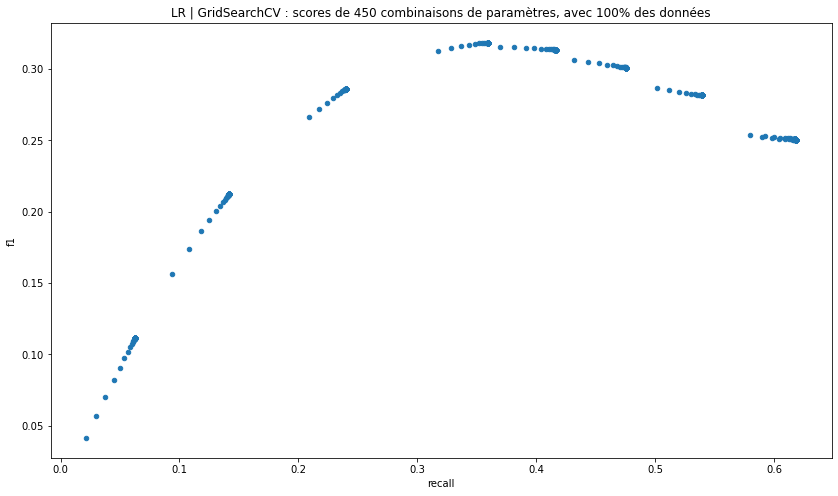

In [21]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=20)

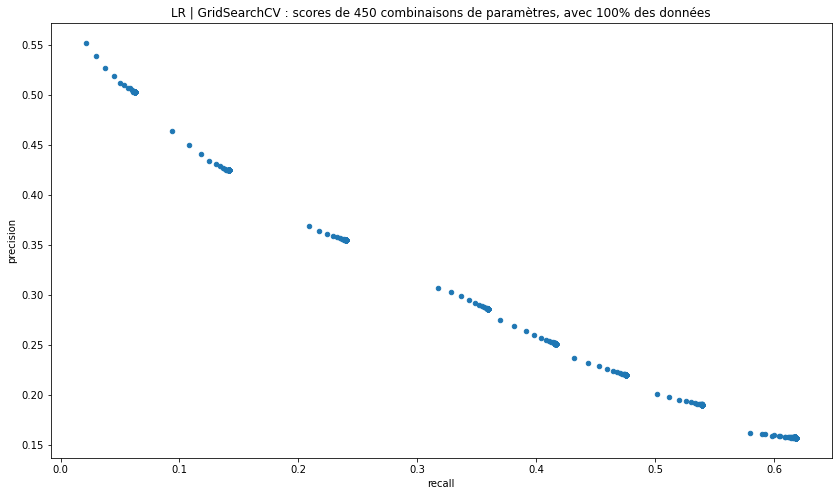

In [22]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=20)

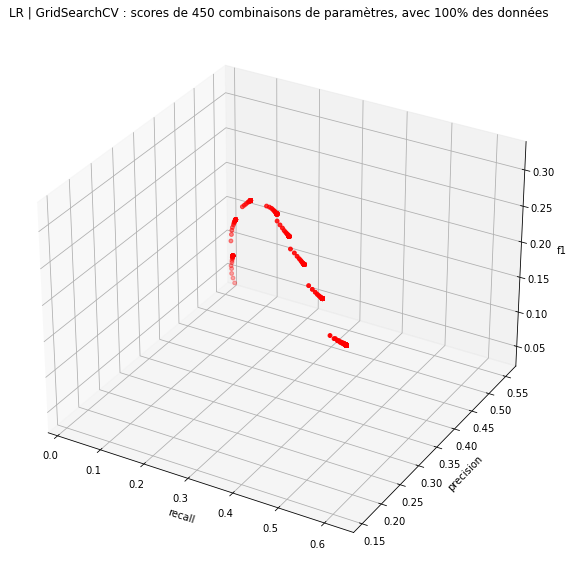

In [23]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=15)

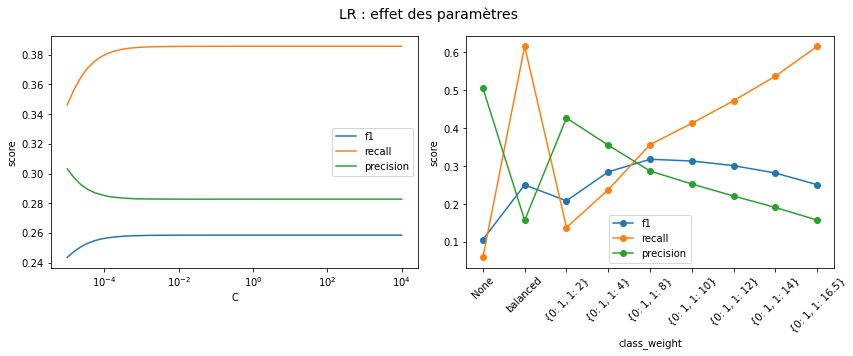

In [24]:
graph_param_CV(dico, results, xscale={'C': 'log'}, ncols=2, height=5, width=6)

In [25]:
best_params = best_score_CV(dico, results, 'recall')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,mean_test_f1,std_test_f1,rank_test_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_test_precision,std_test_precision,rank_test_precision
217,45.184414,4.09253,1.174197,0.144532,0.255955,balanced,"{'C': 0.2559547922699538, 'class_weight': 'bal...",0.250498,0.001211,340,0.6187,0.002529,1,0.15704,0.000799,444
271,48.309379,3.938691,1.117353,0.09107,3.237458,balanced,"{'C': 3.2374575428176464, 'class_weight': 'bal...",0.250503,0.001207,313,0.6187,0.002505,2,0.157044,0.000797,418
343,49.553187,1.617132,1.177625,0.033219,95.409548,balanced,"{'C': 95.40954763499944, 'class_weight': 'bala...",0.250498,0.0012,324,0.6187,0.002505,2,0.15704,0.000792,429
424,47.089582,3.59971,1.178131,0.190736,4291.93426,balanced,"{'C': 4291.934260128778, 'class_weight': 'bala...",0.250498,0.0012,324,0.6187,0.002505,2,0.15704,0.000792,429
262,46.767541,2.441664,1.122382,0.049587,2.120951,balanced,"{'C': 2.1209508879201926, 'class_weight': 'bal...",0.250501,0.001205,315,0.6187,0.002505,2,0.157043,0.000796,421
280,48.824479,2.942137,1.21658,0.163396,4.941713,balanced,"{'C': 4.941713361323838, 'class_weight': 'bala...",0.250501,0.001205,315,0.6187,0.002505,2,0.157043,0.000796,421
289,46.497169,4.079811,1.118809,0.060934,7.54312,balanced,"{'C': 7.543120063354623, 'class_weight': 'bala...",0.250501,0.001205,315,0.6187,0.002505,2,0.157043,0.000796,421
298,46.661901,3.599573,1.132351,0.027089,11.513954,balanced,"{'C': 11.513953993264481, 'class_weight': 'bal...",0.250499,0.001201,322,0.6187,0.002505,2,0.157041,0.000793,426
307,50.162029,2.054367,1.119693,0.011859,17.575106,balanced,"{'C': 17.57510624854793, 'class_weight': 'bala...",0.250499,0.001201,322,0.6187,0.002505,2,0.157041,0.000793,426
415,48.062257,2.457965,1.119794,0.02748,2811.768698,balanced,"{'C': 2811.7686979742366, 'class_weight': 'bal...",0.250498,0.0012,324,0.6187,0.002505,2,0.15704,0.000792,429


{'C': 0.2559547922699538, 'class_weight': 'balanced'}

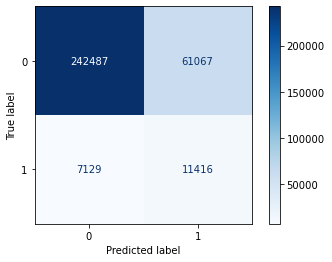

f1 : 0.2508
recall : 0.6156
negative predictive value : 0.9714
precision : 0.1575
roc_auc : 0.7762
CPU times: user 1min 54s, sys: 3min 20s, total: 5min 14s
Wall time: 10.6 s


In [26]:
%%time
m = Modelisation(X, y, LogisticRegression(**best_params), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

## Régression logistique sur la base sur-échantillonnée

**/!\ : Seule la base de training est sur-échantillonnée.**

In [27]:
df_train_res = pd.read_csv('data/df_train_res.csv').sample(frac=1)
print(df_train_res.shape)

(2419276, 22)


In [28]:
df_test_res = pd.read_csv('data/df_test_res.csv').sample(frac=1)
print(df_test_res.shape)

(320711, 22)


In [29]:
datasets_df_train_res = datasets(df_train_res, verbose=False)
X_quant_train_res = datasets_df_train_res['X_quant']
X_cat_train_res = datasets_df_train_res['X_cat']
X_train_res = datasets_df_train_res['X']
y_train_res = datasets_df_train_res['y']

In [30]:
datasets_df_test_res = datasets(df_test_res, verbose=False)
X_quant_test_res = datasets_df_test_res['X_quant']
X_cat_test_res = datasets_df_test_res['X_cat']
X_test_res = datasets_df_test_res['X']
y_test_res = datasets_df_test_res['y']

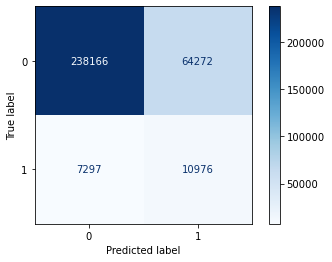

f1 : 0.2347
recall : 0.6007
negative predictive value : 0.9703
precision : 0.1459
roc_auc : 0.7550
CPU times: user 3min 43s, sys: 5min 16s, total: 8min 59s
Wall time: 22 s


In [31]:
%%time
m = Modelisation(X_train_res, y_train_res, LogisticRegression(), X_test=X_test_res, y_test=y_test_res, scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

In [32]:
# SearchCV(model, cv_params, data_frac=1, scaling=True, random=False, csv='data/df_train_res.csv', name='res', n_jobs=28)

In [33]:
dico, results = restauration_CV('LR_CV_Grid_450_1_res')

model : LogisticRegression()
model_name : LR
type : GridSearchCV
len_grid : 450
data_frac : 1
temps : 01:07:45
params : {'C': array([1.00000000e-05, 1.52641797e-05, 2.32995181e-05, 3.55648031e-05,
       5.42867544e-05, 8.28642773e-05, 1.26485522e-04, 1.93069773e-04,
       2.94705170e-04, 4.49843267e-04, 6.86648845e-04, 1.04811313e-03,
       1.59985872e-03, 2.44205309e-03, 3.72759372e-03, 5.68986603e-03,
       8.68511374e-03, 1.32571137e-02, 2.02358965e-02, 3.08884360e-02,
       4.71486636e-02, 7.19685673e-02, 1.09854114e-01, 1.67683294e-01,
       2.55954792e-01, 3.90693994e-01, 5.96362332e-01, 9.10298178e-01,
       1.38949549e+00, 2.12095089e+00, 3.23745754e+00, 4.94171336e+00,
       7.54312006e+00, 1.15139540e+01, 1.75751062e+01, 2.68269580e+01,
       4.09491506e+01, 6.25055193e+01, 9.54095476e+01, 1.45634848e+02,
       2.22299648e+02, 3.39322177e+02, 5.17947468e+02, 7.90604321e+02,
       1.20679264e+03, 1.84206997e+03, 2.81176870e+03, 4.29193426e+03,
       6.55128557e+03,

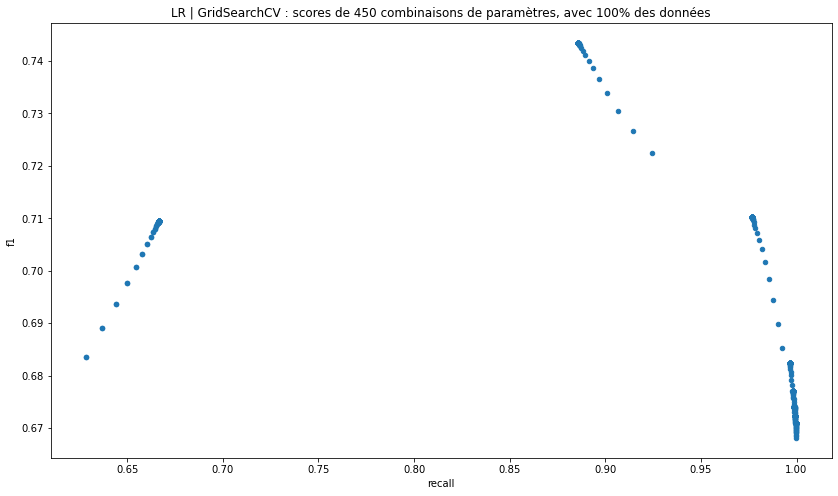

In [34]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=20)

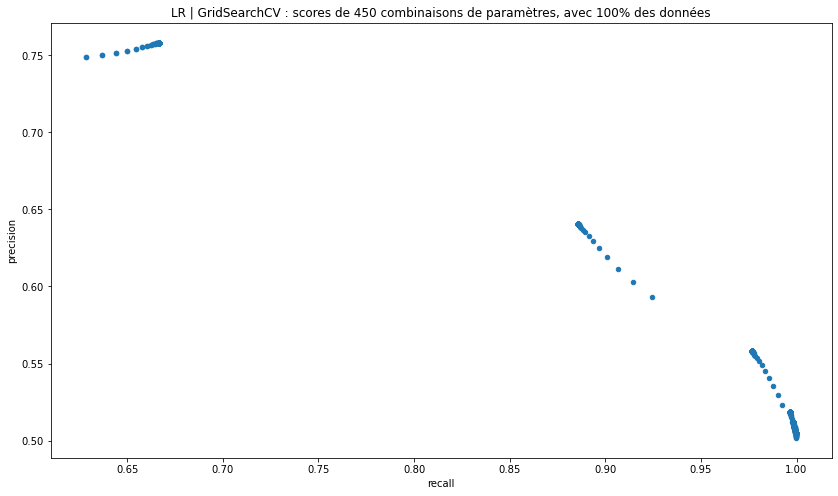

In [35]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=20)

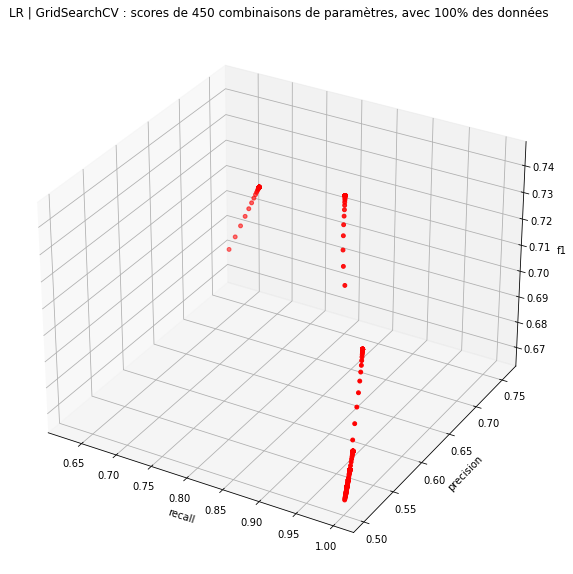

In [36]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=15)

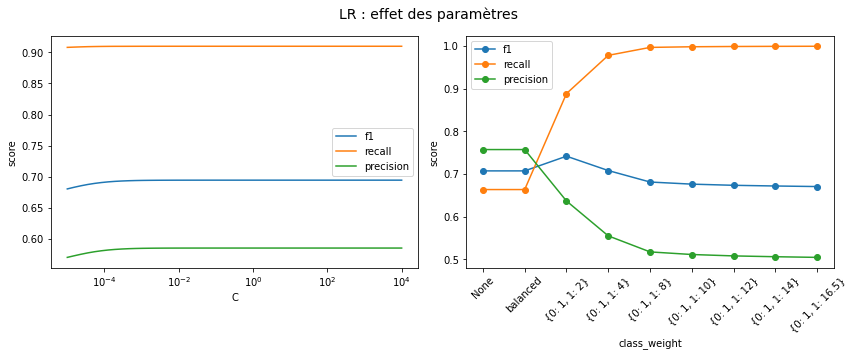

In [37]:
graph_param_CV(dico, results, xscale={'C': 'log'}, ncols=2, height=5, width=6)

In [38]:
best_params = best_score_CV(dico, results, 'recall')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,mean_test_f1,std_test_f1,rank_test_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_test_precision,std_test_precision,rank_test_precision
8,48.304191,2.935628,1.803304,0.228833,0.00001,"{0: 1, 1: 16.5}","{'C': 1e-05, 'class_weight': {0: 1, 1: 16.5}}",0.668103,0.00007,450,0.999876,0.000021,1,0.501649,0.000081,450
17,61.576055,5.952889,1.702155,0.103926,0.000015,"{0: 1, 1: 16.5}","{'C': 1.5264179671752335e-05, 'class_weight': ...",0.668562,0.000066,449,0.999831,0.000021,2,0.502178,0.000078,449
7,49.928577,1.59891,1.800447,0.224947,0.00001,"{0: 1, 1: 14}","{'C': 1e-05, 'class_weight': {0: 1, 1: 14}}",0.668588,0.000063,448,0.999822,0.000023,3,0.502209,0.000076,448
26,66.09769,3.462116,1.807031,0.115153,0.000023,"{0: 1, 1: 16.5}","{'C': 2.3299518105153718e-05, 'class_weight': ...",0.668999,0.000053,447,0.999778,0.000026,4,0.502684,0.000065,447
16,55.528203,6.03303,1.817489,0.094027,0.000015,"{0: 1, 1: 14}","{'C': 1.5264179671752335e-05, 'class_weight': ...",0.669167,0.000042,446,0.999751,0.000023,5,0.502882,0.000051,446
35,70.548624,2.351724,1.708548,0.104922,0.000036,"{0: 1, 1: 16.5}","{'C': 3.5564803062231284e-05, 'class_weight': ...",0.669383,0.000055,444,0.999744,0.000024,6,0.503127,0.000063,444
6,46.906416,2.954388,1.637583,0.165145,0.00001,"{0: 1, 1: 12}","{'C': 1e-05, 'class_weight': {0: 1, 1: 12}}",0.669178,0.000044,445,0.99974,0.000031,7,0.502896,0.000054,445
44,82.002723,6.040876,1.825192,0.183739,0.000054,"{0: 1, 1: 16.5}","{'C': 5.4286754393238594e-05, 'class_weight': ...",0.669713,0.000062,442,0.999707,0.000025,8,0.503509,0.000071,442
25,66.362673,3.62936,1.693121,0.067554,0.000023,"{0: 1, 1: 14}","{'C': 2.3299518105153718e-05, 'class_weight': ...",0.669692,0.000052,443,0.999692,0.000027,9,0.50349,0.000061,443
53,86.36757,2.751691,1.767646,0.042278,0.000083,"{0: 1, 1: 16.5}","{'C': 8.286427728546843e-05, 'class_weight': {...",0.669999,0.000072,440,0.999665,0.000022,10,0.503843,0.000081,440


{'C': 1e-05, 'class_weight': {0: 1, 1: 16.5}}

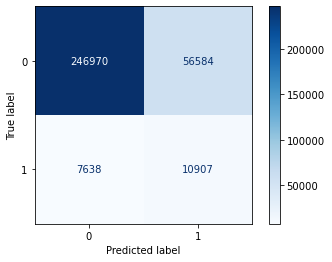

f1 : 0.2535
recall : 0.5881
negative predictive value : 0.9700
precision : 0.1616
roc_auc : 0.7719
CPU times: user 1min 4s, sys: 1min 53s, total: 2min 57s
Wall time: 7.53 s


In [39]:
%%time
m = Modelisation(X, y, LogisticRegression(**best_params), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

In [40]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:04:19
